In [1]:
import tqdm

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import root_scalar
import keras

# custom modules
from models_binary import unet_model, lstm_model, cnn_model

import scienceplots
model = keras.models.load_model('model.keras')

sample_length = 1024
N = 1024

In [2]:
from scipy.io import loadmat
s = loadmat('signal.mat')['s']
median = np.median(s)
dc_thr = median + 25
s = s - dc_thr
s[s < 0] = 0
s = s.astype(np.float32)

def normalize_data(X):
    X = X/3000 - 1
    return X

s = normalize_data(s)

In [3]:
# divide into 1024 samples
def divide_into_samples(X):
    X = X.squeeze()
    X = X[:-(X.shape[0] % sample_length)]
    X = X.reshape(-1, sample_length)
    return X

X_test_exp = divide_into_samples(s)

In [4]:
Xpred_exp = model.predict(X_test_exp).squeeze()

306/306 [==============================] - 24s 65ms/step


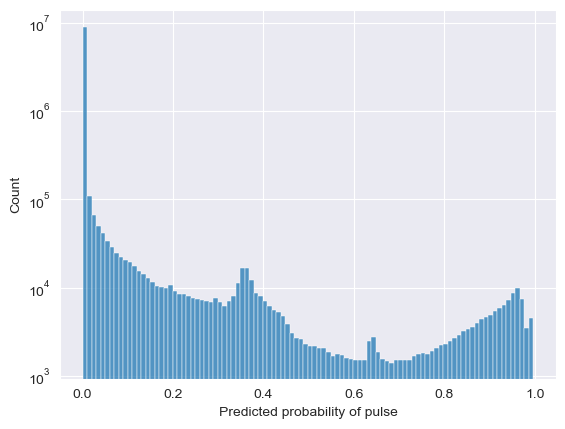

In [5]:
sns.histplot(Xpred_exp.flatten(), bins=100, log=True)
plt.xlabel('Predicted probability of pulse')
plt.ylabel('Count')
plt.show()

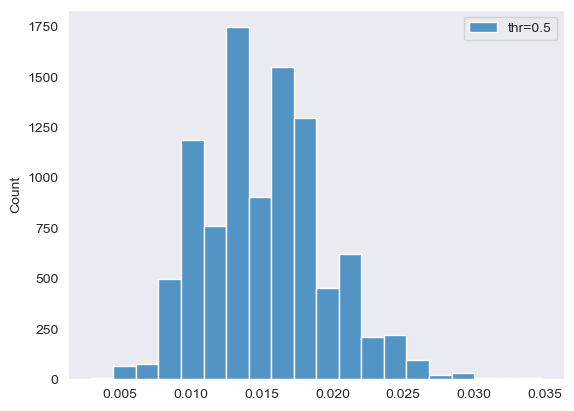

In [6]:
thr = 0.5
Y_pred_exp = (Xpred_exp > thr).astype(np.uint8)
lambda_oracle = -np.log(1 - np.sum(Y_pred_exp, axis=-1) / N)
sns.histplot(lambda_oracle, bins=20, label='thr=0.5')
plt.legend()
plt.grid()
plt.show()

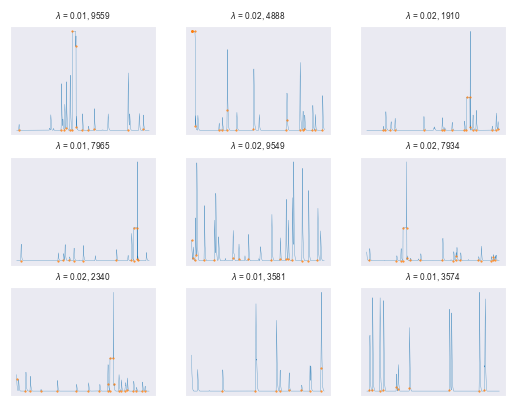

In [7]:
a = np.random.choice(len(X_test_exp), 9, replace=False)
for k, i in enumerate(a):
    plt.subplot(3, 3, k+1)
    plt.plot(X_test_exp[i], linewidth=0.2)
    idx_plt = np.where(Y_pred_exp[i])[0]
    plt.plot(idx_plt, X_test_exp[i][idx_plt], 'o', markersize=0.5)
    plt.title(r'$\lambda$ = {:.2f}, {}'.format(-np.log(1 - len(idx_plt) / N), i), fontsize=6)
    plt.xticks([])
    plt.yticks([])
plt.show()

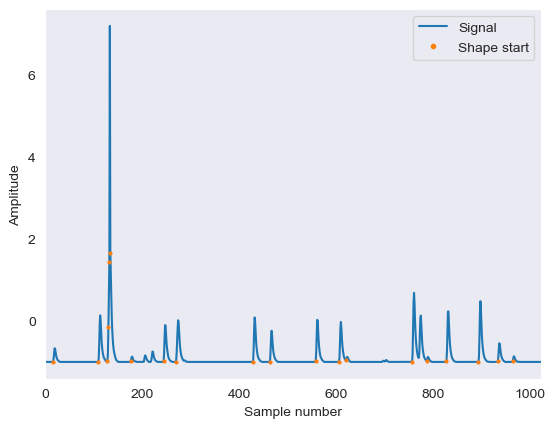

In [8]:
i = 11
segm = X_test_exp[i]
plt.plot(segm)
idx_plt = np.where(Y_pred_exp[i])[0]
plt.plot(idx_plt, segm[idx_plt], 'o', markersize=2)
plt.grid()
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.xlim(0, 1024)
lgnd = plt.legend(['Signal', 'Shape start'],scatterpoints=20)
lgnd.legendHandles[1].set_markersize(3)
plt.savefig('exp_example.pdf')
plt.savefig('exp_example.png')
plt.show()